# DSP. Assignment 3

**Students**: Anna Boronina, Pavel Tishkin

**Emails**: a.boronina@innopolis.university, p.tishkin@innopolis.university

**Group**: BS18-DS-02


### Task 1

To start off, that's where we had our audio recorded:

<div align="center">
<img src=https://drive.google.com/uc?export=view&id=1QcaYU2_Jd4aZkHHsUlBmgca7jUVF3bK6 width="300">
</div>



In [ ]:
from IPython.display import Audio

original = './clap.ogg'
print('warning: for some reason jupyter notebook doesn\'t want to play such short recording but it\'s ok in colab')
Audio(filename=original)

We have done some preprocessing using [this website](https://audiotrimmer.com/#):
1. shifted the recording so that the clup is at the very beginning
2. added fading out effect

What we have got after is below. It will be our kernel.

In [ ]:
preprocessed = './clap_cut_ffmpeg.ogg'
print('warning: for some reason jupyter notebook doesn\'t want to play such short recording but it\'s ok in colab')
Audio(filename=preprocessed)

Let's normalize the recording and plot it. We can see that the signal is decaying: the closer to the end, the smaller signal's amplitude.

shape: (22050,), max value after normalization: 1.0


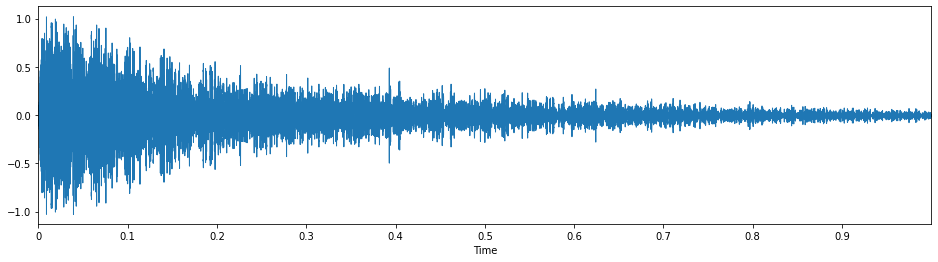

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import warnings
warnings.filterwarnings('ignore')

x, sr = librosa.load(original)
x = x / np.max(x)

print(f'shape: {x.shape}, max value after normalization: {max(x)}')

plt.figure(figsize=(16, 4))
librosa.display.waveplot(x, sr=sr)

### Task 2

Let's convolve our signal with Dirac delta function $\delta$:

<div align="center">
<img src=https://drive.google.com/uc?export=view&id=1vFDe8I2Ny-t-EMpLT42FU9-rFOZtzy3L width="150">
</div>

What we have done to optimize the process of convolution:
1. used njit from numba. njit compiles and runs in nopython mode, which is the best approach

In [ ]:
from scipy.signal import unit_impulse
from numba import njit
from math import sqrt


def fft_convolve(x, h):
    size = len(x) + len(h) - 1
    fft_x = np.fft.fft(x, size)
    fft_h = np.fft.fft(h, size)
    assert len(fft_x) == len(fft_h), 'Lengths of fft_x and fft_h must be the same'

    mul_result = []
    for i in range(len(fft_x)):
        mul_result.append(fft_x[i] * fft_h[i])
    ifft_result = np.fft.ifft(mul_result)
    result = []
    for i, elem, in enumerate(np.fft.ifft(mul_result)):
        result.append(sqrt(np.real(elem)**2 + np.imag(elem)**2))
    return np.array(result)


@njit
def get_elem(x, i):
    return 0 if i < 0 or i >= len(x) else x[i]


@njit(parallel=True)
def reg_convolve(x, h):
    size = len(x) + len(h) - 1
    window = len(x)
    result = []
    for n in range(size):
        gen = np.sum(np.array([get_elem(x, k) * get_elem(h, n-k) for k in range(window)]))
        result.append(gen)
    return np.array(result)


def convolve(x, h, fft_based=False):
    if fft_based:
        return fft_convolve(x, h)
    else:
        return reg_convolve(x, h)

Let's time the regular convolution approach:

In [ ]:
from numpy.random import randint
temp_x = randint(low=0, high=2, size=1000)
temp_h = randint(low=0, high=100, size=10000)
%time
convolve(temp_x, temp_h)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 12.9 µs


array([  0,  80, 145, ..., 110,  21,   0])

Now let's time FFT-based convolution approach:

In [ ]:
%time
convolve(temp_x, temp_h, fft_based=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.5 µs


array([9.09494702e-12, 8.00000000e+01, 1.45000000e+02, ...,
       1.10000000e+02, 2.10000000e+01, 1.16472151e-11])

To make sure it's also correct, let's use `np.convolve` to compare the results:

In [ ]:
from scipy.signal import fftconvolve

conv_regular = convolve(temp_x, temp_h)
np_conv_regular = np.convolve(temp_x, temp_h)
print(f'our regular: {conv_regular}')
print(f'np.convolve: {np_conv_regular}\n')
print(f'our regular size: {len(conv_regular)}, np.convolve size: {len(np_conv_regular)}\n\n')

conv_fft = convolve(temp_x, temp_h, fft_based=True)
scipy_conv_fft = fftconvolve(temp_x, temp_h)
print(f'our FFT:                  {conv_fft}')
print(f'scipy.signal.fftconvolve: {scipy_conv_fft}\n')
print(f'our FFT size: {len(conv_fft)}, scipy.signal.fftconvolve: {len(scipy_conv_fft)}')

our regular: [  0  80 145 ... 110  21   0]
np.convolve: [  0  80 145 ... 110  21   0]

our regular size: 10999, np.convolve size: 10999


our FFT:                  [9.09494702e-12 8.00000000e+01 1.45000000e+02 ... 1.10000000e+02
 2.10000000e+01 1.16472151e-11]
scipy.signal.fftconvolve: [ 0.00000000e+00  8.00000000e+01  1.45000000e+02 ...  1.10000000e+02
  2.10000000e+01 -2.64909532e-12]

our FFT size: 10999, scipy.signal.fftconvolve: 10999


### Task 3

Let's try to apply our filter to some recordings, but we need to load the recordings themselves first:

In [6]:
sounds_dir = './DSP_2020_A3_DATA'
drums = 'drums.wav'
music_20s = 'music_20s_8000.wav'
speech = 'speech.wav'
violin = 'violin.wav'
voice = 'voice.wav'

def path(rec):
    return f'{sounds_dir}/{rec}'

print('drumsssss: ')
Audio(filename=path(drums))

drumsssss: 


NameError: ignored

In [ ]:
x_drums, sr_drums = librosa.load(path(drums))
x_music_20s, sr_music_20s = librosa.load(path(music_20s))
x_speech, sr_speech = librosa.load(path(speech))
x_violin, sr_violin = librosa.load(path(violin))
x_voice, sr_voice = librosa.load(path(voice))

In [ ]:
sample_rates = {
    'drums': 48000,
    'music_20s': 8000,
    'speech': 44100,
    'violin': 96000,
    'voice': 48000
}

In [ ]:
conv_results = {
    'drums': convolve(x_drums, x),
    'music_20s': convolve(x_music_20s, x),
    'speech': convolve(x_speech, x),
    'violin': convolve(x_violin, x),
    'voice': convolve(x_voice, x)
}

You can compare any recording in its before state and after:

In [ ]:
sound = 'speech'
Audio(x_speech, rate=sample_rates[sound]/2)

In [ ]:
Audio(conv_results[sound], rate=sample_rates[sound]/2)

### Task 4

### Task 4

First of all, let us start with the definitions of the Linear Convolution and Circular convolution
* **Linear Convolution:** The linear convolution of finite signals is defined by extending the
finite signals as two-side infinite sequences that are zeros outside
support of the signals. If signal has finite support ($[0; m]$ in our case):
$$(x \star y)_n = \sum_{k \in \mathbf{Z}}x_ky_{n-k} = \sum_{k \in [0;m-1]}x_ky_{n-k}$$
* **Circular Convolution:** Circular convolution between two finite sequences $x$ and $y$ of some fixed length $m>0$ is the following sequence of the same length $m$:
$$(x^{(\star)}y)_n = \sum_{k=0}^{m-1}x_ky_{(n-k)mod\ m}$$

**Theorem:**  Linear and circular convolutions between finite sequences $x$ and $y$ are equivalent when the period of the circular convolution $m$ satisfies the following inequality $m \ge m_x+m_y - 1$ where $m_x$ and $m_y$ are size of $x$ and $y$ supports respectively.  
**Proof:** Let us take $$x = \begin{pmatrix} \mathbf{x_0} & x_1 & ... & x_{m_x-1} \end{pmatrix}$$ $$y = \begin{pmatrix} \mathbf{y_0} & y_1 & ... & y_{m_y-1} \end{pmatrix}$$ and arbitrary $m>m_x + m_y-1$.  
Firstly, we need to extend signals to the length of support $m$:
$$x = \begin{pmatrix} \mathbf{x_0} & x_1 & ... & x_{m_x-1} & 0 & ... & x_{m-1}=0 \end{pmatrix}$$
$$y = \begin{pmatrix} \mathbf{y_0} & y_1 & ... & y_{m_y-1} & 0 & ... & y_{m-1} = 0 \end{pmatrix}$$
Let us calculate Linear and Circular convolutions of these two sequences:
* **Linear Convolution:** Let us extend the signals to infinite signals:
$$x = \begin{pmatrix} ... & 0 & \mathbf{x_0} & x_1 & ... & x_{m_x-1} & 0 & ... & x_{m-1}=0 & ... \end{pmatrix}$$
$$y = \begin{pmatrix} ... & 0 & \mathbf{y_0} & y_1 & ... & y_{m_y-1} & 0 & ... & y_{m-1} = 0 & ... \end{pmatrix}$$
Then, we will compute convolution using the fact these signals have finite support $m$:
$$(x \star y)_n = \sum_{k \in \mathbf{Z}} x_ky_{n-k} = \sum_{k \in [0;m-1]} x_ky_{n-k} = (x_0y_n + x_1y_{n-1} + ... + x_0y_{n}) + (x_{n+1}y_{-1} + x_{n+2}y_{-2} + ... + x_{m_x-1}y_{n-(m_x-1)})$$
Let us analyze the second brackets. The multiplications in them include the elements $y_k=0, k\le-1$, since we extended $y$ with zeros. Therefore, the products will be equal to $0$ and, as a result, the whole sum in brackets will be $0$:
$$(x_0y_n + x_1y_{n-1} + ... + x_0y_{n}) + (x_{n+1}y{-1} + x_{n+2}y_{-2} + ... + x_{m_x-1}y_{n-(m_x)-1}) = (x_0y_n + x_1y_{n-1} + ... + x_0y_{n})$$
* **Circular convolution:**
$$(x^{(\star)}y)_n = \sum_{k=0}^{m-1}x_ky_{(n-k)mod\ m} = (x_0y_n + x_1y_{n-1} + ... + x_ny_0) + (x_{n+1}y_{(-1)mod\ m} + x_{n+2}y_{(-2)mod\ m} + ... + x_{m_x}y_{(n-(m_x-1))mod\ m}) = (x_0y_n + x_1y_{n-1} + ... + x_ny_0) + (x_{n+1}y_{m-1} + x_{n+2}y_{m-2} + ... + x_{m_x}y_{(m + n - (m_x-1))})$$ 
Let us analyze the second brackets. The elements, taken from signal $y_k$, $k\in [m + n - (m_x-1); m-1]$. Since we extended $y$ by zeros, the only non-zero values of $y$ have indeces $[0; m_y-1]$. The least index from the one we are taking is: 
$$m + n - (m_x-1) \ge m_x+m_y-1 +n - m_x +1 = m_y + n > m_y$$
Therefore, $y_{m + n - (m_x-1)} = 0$ and all the consecutive elements. All of the products in the brackets equal to $0$ and, therefore, the whole sum is $0$:
$$ (x_0y_n + x_1y_{n-1} + ... + x_ny_0) + (x_{n+1}y_{m-1} + x_{n+2}y_{m-2} + ... + x_{m_x}y_{(m + n - (m_x-1))}) = (x_0y_n + x_1y_{n-1} + ... + x_ny_0)$$ 

As a result we got:
$$ (x \star y)_n = (x_0y_n + x_1y_{n-1} + ... + x_ny_0) = (x^{(\star)}y)_n \ \blacksquare$$

### Task 5

аня

In [ ]:
# тут сделать сравнение комплекситис

## Task 2

### Part 1

The equation of the Canonical form is the following:
$$y_k = \sum_{m=0}^M b_mf_{k-m}$$
$$f_l = x_l + \sum_{n=1}^N a_nf_{l-n}$$

### Part 2

In [2]:
from numba import jit


@jit(nopython=True)
def IIR(signal, a, b):
    l_a = a.shape[0]
    l_b = b.shape[0]
    assert l_a == l_b-1, 'Length of a must be len(b)-1'
    res_b = np.zeros(signal.shape[0])
    for i in range(signal.shape[0]):
        for j in range(l_b):
            if i-j >= 0:
                res_b[i]+=b[j]*signal[i-j]
        for j in range(l_a):
            if i-(j+1) >= 0:
                res_b[i]+=a[j]*res_b[i-(j+1)]
    return res_b

### Part 3

In [4]:
# Lowpass, starts cutting frequencies after 20Hz
# Better to listen in your headphones
a_low = np.r_[1.9733442497812987,
 -0.9736948719763]# coefficients for a_1 and a_2
b_low = np.r_[0.00008765554875401547,
 0.00017531109750803094,
 0.00008765554875401547] # coefficients for b_0, b_1 and b_2
# Highpass, starts passing frequencies after 3kHz
a_high = np.r_[-0.3769782747249014,
 -0.19680764477614976] # coefficients for a_1 and a_2
b_high = np.r_[0.40495734254626874,
 -0.8099146850925375,
 0.4049573425462687] # coefficients for b_0, b_1 and b_2

### Part 4

In [7]:
from scipy.io.wavfile import read
# Reading signal
rate, signal = read(path(music_20s))

FileNotFoundError: ignored

In [ ]:
# Lowpass filter
low = IIR(signal, a_low, b_low)
# Highpass filter
high = IIR(signal, a_high, b_high)

In [ ]:

# Listening to the result (Lowpass filter)
print('Lowpass Filter:')
Audio(low, rate=rate)
# Listening to the result (Highpass filter)
print('Highpass Filter:')
Audio(high, rate=rate)

### Part 5

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html

from scipy.fft import fft, fftfreq
# FFT of original signal
# Number of sample points
N = signal.shape[0]
# sample spacing
T = 1.0 / rate
signal_yf = fft(signal)
signal_xf = fftfreq(N, T)
# FFT of lowpass filter
low_yf = fft(low)
low_xf = fftfreq(N, T)[0:N//2]
# FFT of highpass filter
high_yf = fft(high)
high_xf = fftfreq(N, T)

In [ ]:
# Plotting Low-Pass:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(signal_xf[0:N//2], 2.0/N * np.abs(signal_yf[0:N//2]), label = 'Original Signal')
plt.plot(low_xf, 2.0/N * np.abs(low_yf[0:N//2]), label = 'Lowpass Signal')
plt.legend()
plt.xlabel('Log Frequency, HZ')
plt.ylabel('Log Magnitude')
plt.yscale('log')
plt.xscale('log')
# Plotting High-Pass
plt.figure(figsize=(10, 6))
plt.plot(signal_xf[0:N//2], 2.0/N * np.abs(signal_yf[0:N//2]), label = 'Original Signal')
plt.plot(high_xf[0:N//2], 2.0/N * np.abs(high_yf[0:N//2]), label = 'Highpass Signal')
plt.legend()
plt.xlabel('Frequency, HZ')
plt.ylabel('Log Magnitude')
plt.yscale('log')
plt.show()